In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from scipy.stats import pearsonr
from itertools import combinations
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (mean_squared_error, roc_curve, accuracy_score, 
                             f1_score, confusion_matrix, ConfusionMatrixDisplay,
                             RocCurveDisplay, auc)
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

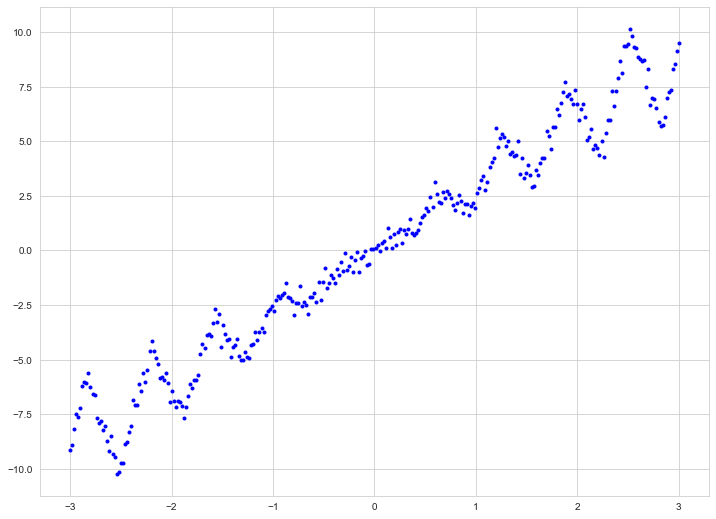

In [8]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

> Я немного изменил функцию, чтобы сразу отразить разные варианты глубины

In [57]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    fig, axs = plt.subplots(nrows = 15, figsize=(10, 60))
    for depth in range(1,16):
        tree_reg = DecisionTreeRegressor(max_depth = depth)
        tree_reg.fit(X, y)
        x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
        y_pred = tree_reg.predict(x1)
        axs[depth - 1].axis(axes)
        #axs[depth - 1].set_xlabel("$x_1$", fontsize=18)
        if ylabel:
            axs[depth - 1].set_ylabel(ylabel, fontsize=18, rotation=0)
        axs[depth - 1].set_title(f'Max depth = {depth}') 
        axs[depth - 1].plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

In [179]:
tree_reg = DecisionTreeRegressor(max_depth = 8)
tree_reg.fit(X, y)
y_pred = tree_reg.predict_proba(X)

AttributeError: 'DecisionTreeRegressor' object has no attribute 'predict_proba'

In [178]:
y_pred - y

array([[  0.        ,   0.23120546,   0.93092761, ...,  17.647818  ,
         18.25407673,  18.63586392],
       [ -0.23120546,   0.        ,   0.69972215, ...,  17.41661254,
         18.02287127,  18.40465846],
       [ -0.93092761,  -0.69972215,   0.        , ...,  16.71689039,
         17.32314913,  17.70493631],
       ...,
       [-17.647818  , -17.41661254, -16.71689039, ...,   0.        ,
          0.60625873,   0.98804592],
       [-18.25407673, -18.02287127, -17.32314913, ...,  -0.60625873,
          0.        ,   0.38178719],
       [-18.63586392, -18.40465846, -17.70493631, ...,  -0.98804592,
         -0.38178719,   0.        ]])

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [58]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

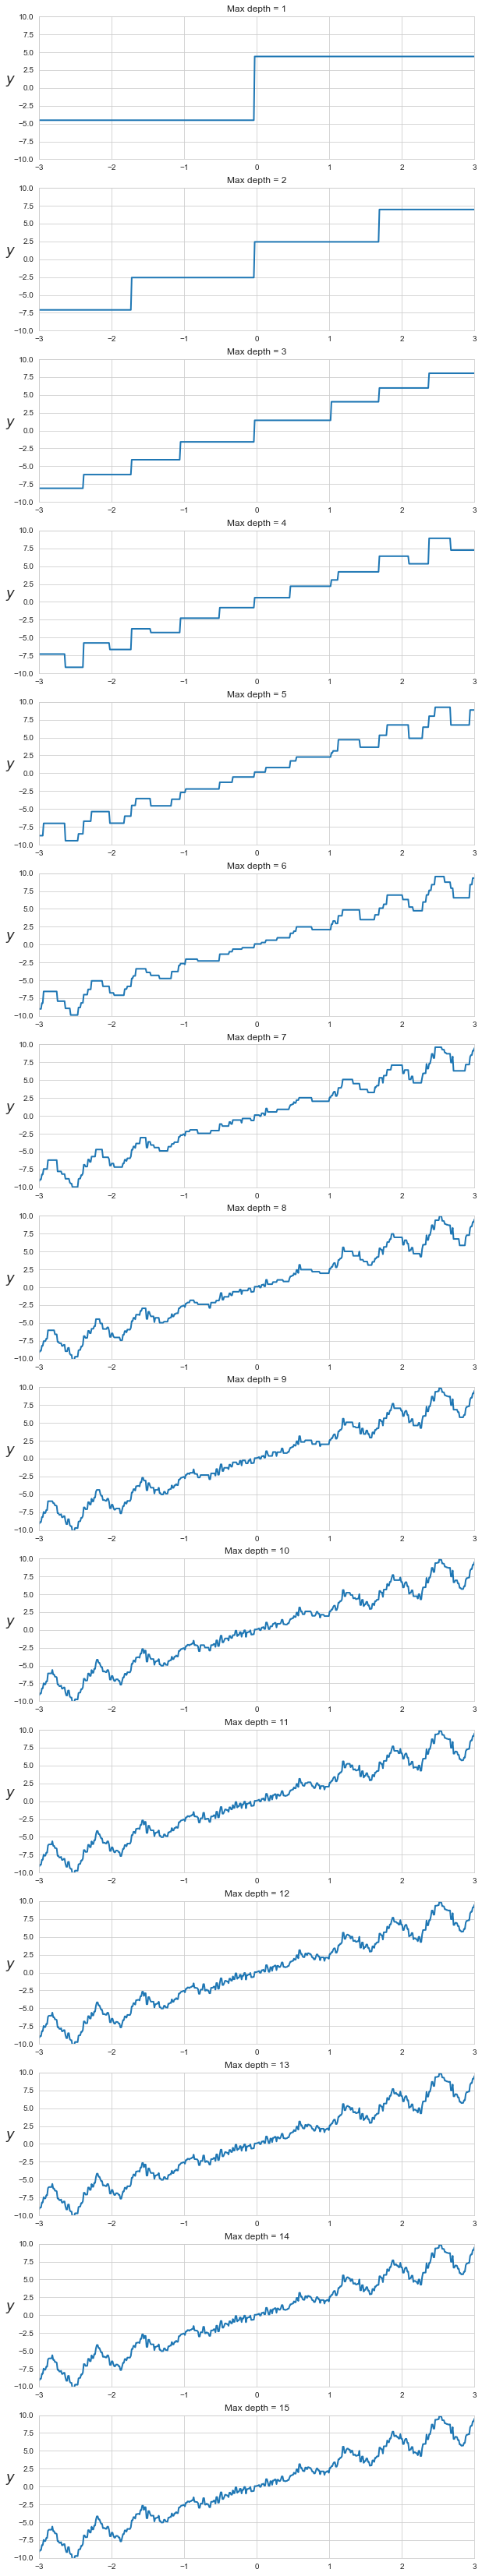

In [59]:
plot_regression_predictions(X, y)

> Кажется, что оптимальная модель достигается при глубине обучения равным 9, тогда модель уже преодолевает недообучения, а при 11-12 и дальше начинает переучиваться 

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [3]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [108]:
def separate_probabiloity(i, p):
    comb = math.factorial(101) / (math.factorial(101 - i) * math.factorial(i))
    mu_now = comb * (p ** i) * ((1 - p) ** (101-i))
    return mu_now

In [109]:
mu_record = []
for p in np.linspace(0, 1, 100):
    mu = 0
    for i in range(51, 102): 
        mu += separate_probabiloity(i, p)
    mu_record.append(mu)

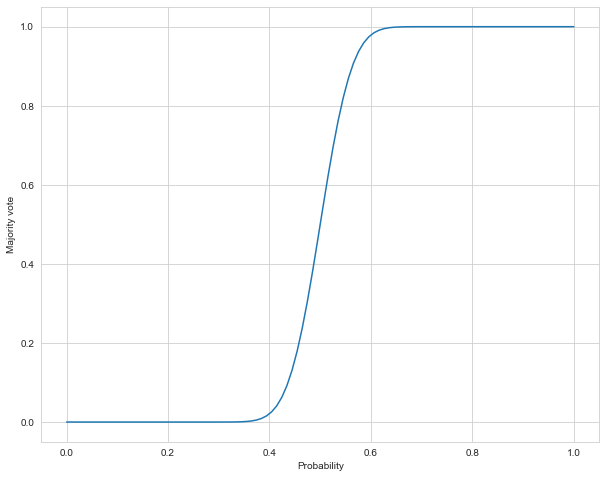

In [110]:
plt.figure(figsize=(10,8))
plt.plot(np.linspace(0, 1, 100), mu_record)
plt.xlabel('Probability')
plt.ylabel('Majority vote');

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [4]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [115]:
def separate_probability(all_model, i, p):
    comb = math.factorial(all_model) / (math.factorial(all_model - i) * math.factorial(i))
    mu_now = comb * (p ** i) * ((1 - p) ** (all_model-i))
    return mu_now

In [161]:
mu_record = []
for k in range(1, 201,2):
    mu = 0
    for i in range(k // 2 + k % 2, k+1): 
        mu += separate_probability(k, i, .65)
    mu_record.append(mu)

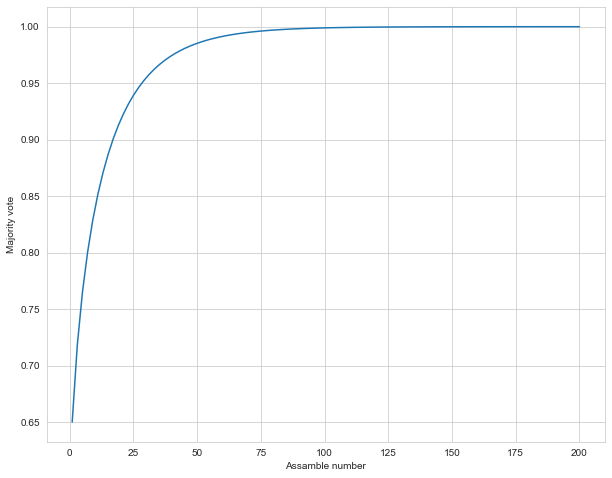

In [162]:
plt.figure(figsize=(10,8))
plt.plot(np.linspace(1, 200, 100).reshape(-1,1), mu_record)
plt.xlabel('Assamble number')
plt.ylabel('Majority vote');

Опишите ваши наблюдения:

* При вероятности p>0.6 вероятность верного предсказания класса на комбинации 51 модели из 101 становиться близкой или равной 1
* При p=0.65 при превышении порога в 80 моделей, вероятность верного предсказания становится максимальной

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [191]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            self.seed_fit = np.random.seed(self.random_state + i)
            self.feat_ids_by_tree.append(np.random.choice(X.shape[1], self.max_features, replace=False))
            bootstrep_X = np.random.choice(X.shape[0], X.shape[0], replace=True)
            random_X = X[b]
            new_X = random_X[:,self.feat_ids_by_tree[i]]
            new_y = y[b]
            
            tree = DecisionTreeClassifier(max_depth = self.max_depth, 
                                          max_features = self.max_features,
                                          random_state = self.seed_fit)
            tree.fit(new_X, new_y)
            self.trees.append(tree)
            
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        proba = []
        for i in range(self.n_estimators):
            proba.append(self.trees[i].predict_proba(X[:,self.feat_ids_by_tree[i]]))
        result = np.mean(proba, axis = 0)
        return result
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [182]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

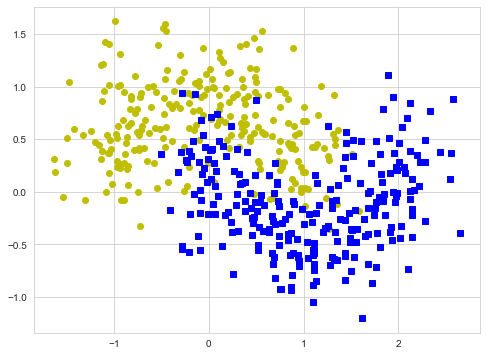

In [183]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

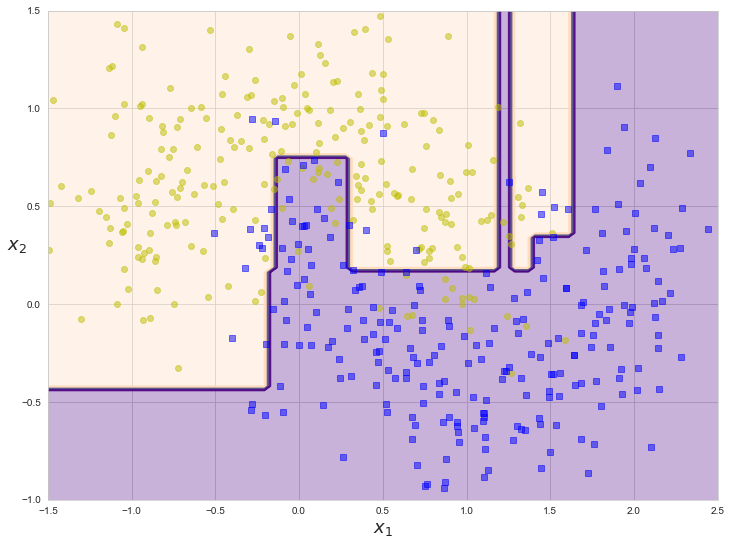

In [192]:
forest = RandomForestClassifierCustom(max_depth=5, n_estimators=100, max_features=2)
forest.fit(X, y)
plot_decision_boundary(forest, X, y)

> Вроде недоучена, сейчас посмотрим на разные гиперпараметры

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [202]:
for depth in range(1, 22, 4):
    for est in range(1, 50, 5):
        random_forest = RandomForestClassifierCustom(max_depth=depth, n_estimators=est, max_features=2, random_state=SEED)
        random_forest.fit(X_train, y_train)
        y_pred = random_forest.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        print(f'depth = {depth}, n_estimators = {est}, mse={mse}, accuracy={accuracy}')

depth = 1, n_estimators = 1, mse=0.2, accuracy=0.8
depth = 1, n_estimators = 6, mse=0.2, accuracy=0.8
depth = 1, n_estimators = 11, mse=0.2, accuracy=0.8
depth = 1, n_estimators = 16, mse=0.2, accuracy=0.8
depth = 1, n_estimators = 21, mse=0.2, accuracy=0.8
depth = 1, n_estimators = 26, mse=0.2, accuracy=0.8
depth = 1, n_estimators = 31, mse=0.2, accuracy=0.8
depth = 1, n_estimators = 36, mse=0.2, accuracy=0.8
depth = 1, n_estimators = 41, mse=0.2, accuracy=0.8
depth = 1, n_estimators = 46, mse=0.2, accuracy=0.8
depth = 5, n_estimators = 1, mse=0.152, accuracy=0.848
depth = 5, n_estimators = 6, mse=0.16, accuracy=0.84
depth = 5, n_estimators = 11, mse=0.16, accuracy=0.84
depth = 5, n_estimators = 16, mse=0.16, accuracy=0.84
depth = 5, n_estimators = 21, mse=0.16, accuracy=0.84
depth = 5, n_estimators = 26, mse=0.152, accuracy=0.848
depth = 5, n_estimators = 31, mse=0.16, accuracy=0.84
depth = 5, n_estimators = 36, mse=0.16, accuracy=0.84
depth = 5, n_estimators = 41, mse=0.16, accuracy

> По ручным данным я бы взял depth = 9, n_estimators = 11

In [ ]:
forest_params = {'max_depth': range(1,30),
                 'n_estimators': range(3,60)}
random_forest = RandomForestClassifierCustom(max_features=2, random_state=SEED)

tree_grid = GridSearchCV(estimator=random_forest, param_grid=forest_params, scoring="accuracy", cv=5, n_jobs=-1)

tree_grid.fit(X_train, y_train)
tree_grid.best_params_

{'max_depth': 6, 'n_estimators': 3}

> Построим 2 графика с разными гиперпараметрами - результат одинаковый

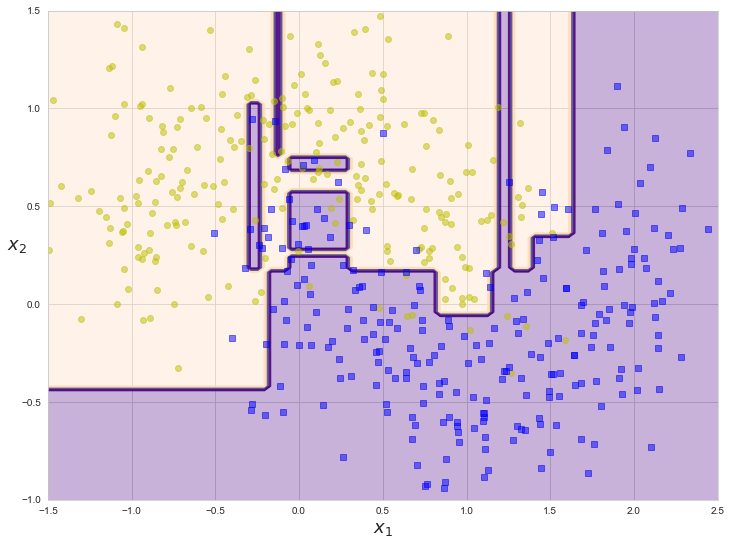

In [217]:
forest = RandomForestClassifierCustom(max_depth=9, n_estimators=11, max_features=2)
forest.fit(X, y)
plot_decision_boundary(forest, X, y)

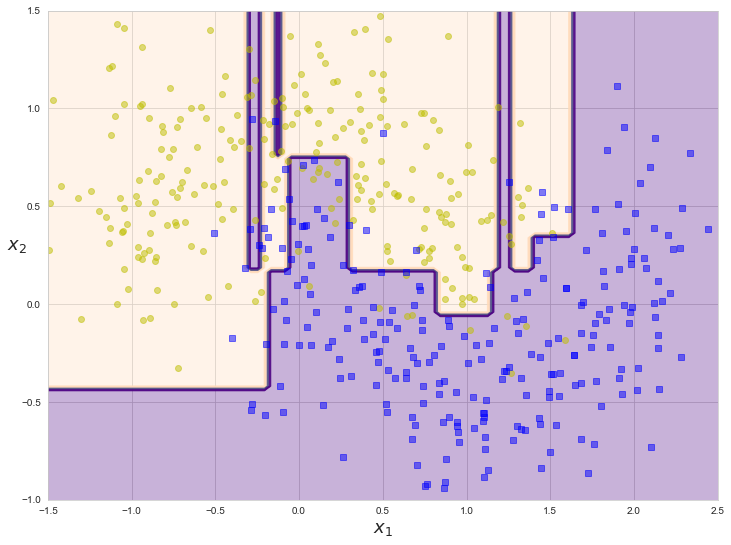

In [218]:
forest = RandomForestClassifierCustom(max_depth=6, n_estimators=3, max_features=2)
forest.fit(X, y)
plot_decision_boundary(forest, X, y)

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [219]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [220]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [222]:
X

(569, 30)

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [224]:
pearson_cor = []

for features in [1, 2, 3, 4, 5, 10, 20, 30]:
    rand_forest = RandomForestClassifier(max_features = features)
    rand_forest.fit(X_train, y_train)
    pearson_cor.append(base_model_pair_correlation(rand_forest, X_test))

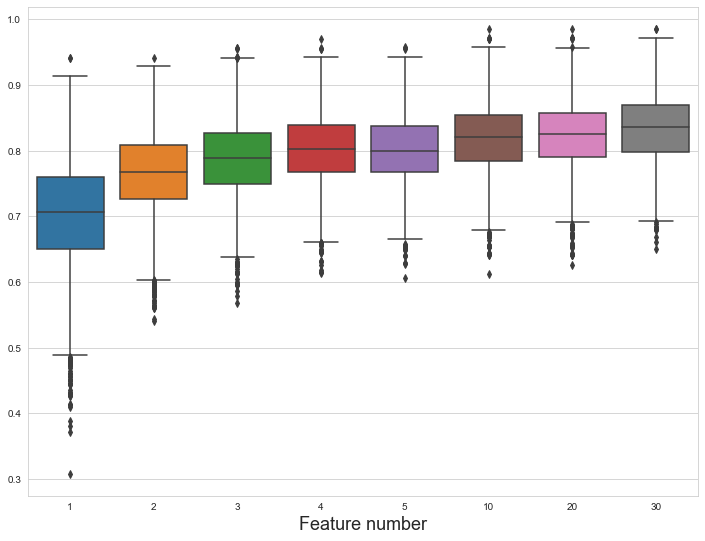

In [249]:
fig = sns.boxplot(data=pearson_cor)
plt.xlabel('Feature number', fontsize=18)
fig.set_xticklabels(['1', '2', '3', '4', '5', '10', '20', '30']);

Опишите ваши наблюдения:

* На первой стадии корреляция заметно увеличивается, потом скорость нарастания снижается
* При значениии фичей 4 и 5 корреляция оптимальна - предсказания еще не слишком сильно согласуются, но и модель неплохо сопоставляет предсказания

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [252]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

C:\Users\ornfi\anaconda3\lib\site-packages\gdown\cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [253]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [254]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [256]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models)
voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8379629629629629
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [258]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [259]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [537]:
voting_soft.fit(X_train, y_train)
correlation_soft = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

> Бегло взглянем, какие модели дают высокую корреляцию

In [280]:
potential_out = []
for i in range(len(correlation_soft)):
    if correlation_soft[i][2] > 0.85:
        print(correlation_soft[i][0].__class__.__name__, correlation_soft[i][1].__class__.__name__,
              correlation_soft[i][2])
        potential_out.append([correlation_soft[i][0].__class__.__name__, correlation_soft[i][1].__class__.__name__,
              correlation_soft[i][2]])           

DecisionTreeClassifier LGBMClassifier 0.8612656428887719
DecisionTreeClassifier XGBRFClassifier 0.8857896825439963
RandomForestClassifier ExtraTreesClassifier 0.9215651183028868
RandomForestClassifier CatBoostClassifier 0.9450698035153571
RandomForestClassifier LGBMClassifier 0.9146873011990888
RandomForestClassifier LGBMClassifier 0.9146686698479997
RandomForestClassifier XGBClassifier 0.9020060270059165
RandomForestClassifier XGBRFClassifier 0.934219466501618
ExtraTreesClassifier SVC 0.8877787556939445
ExtraTreesClassifier CatBoostClassifier 0.9527199736215166
ExtraTreesClassifier LGBMClassifier 0.8928745278265378
ExtraTreesClassifier LGBMClassifier 0.8593025495570129
ExtraTreesClassifier XGBClassifier 0.868802002640176
ExtraTreesClassifier XGBRFClassifier 0.8916524520649183
ExtraTreesClassifier LogisticRegression 0.8693493059659243
ExtraTreesClassifier GaussianNB 0.8522994111599134
SVC CatBoostClassifier 0.8628125177507158
SVC LogisticRegression 0.9521722912987505
CatBoostClassifier

> Оценка того, какие чаще всего встречаются в этом списке

In [288]:
dataframe = pd.DataFrame(potential_out)
dataframe[0].value_counts()

ExtraTreesClassifier      8
RandomForestClassifier    6
CatBoostClassifier        5
LGBMClassifier            4
DecisionTreeClassifier    2
SVC                       2
XGBClassifier             1
LogisticRegression        1
Name: 0, dtype: int64

In [289]:
dataframe[1].value_counts()

LGBMClassifier          8
XGBRFClassifier         7
XGBClassifier           4
CatBoostClassifier      3
LogisticRegression      3
GaussianNB              2
ExtraTreesClassifier    1
SVC                     1
Name: 1, dtype: int64

> И их вклад

In [297]:
dataframe.sort_values(by=[2], ascending=False)

,0,1,2
24,LGBMClassifier,XGBClassifier,0.963439
18,CatBoostClassifier,LGBMClassifier,0.955278
9,ExtraTreesClassifier,CatBoostClassifier,0.952720
17,SVC,LogisticRegression,0.952172
3,RandomForestClassifier,CatBoostClassifier,0.945070
27,XGBClassifier,XGBRFClassifier,0.944682
25,LGBMClassifier,XGBRFClassifier,0.940465
20,CatBoostClassifier,XGBClassifier,0.934455
7,RandomForestClassifier,XGBRFClassifier,0.934219
21,CatBoostClassifier,XGBRFClassifier,0.932996


In [300]:
dataframe.groupby([0]).agg('sum')

,2
0,
CatBoostClassifier,4.575408
DecisionTreeClassifier,1.747055
ExtraTreesClassifier,7.074779
LGBMClassifier,3.680845
LogisticRegression,0.892515
RandomForestClassifier,5.532216
SVC,1.814985
XGBClassifier,0.944682


In [302]:
dataframe.groupby([1]).agg('sum')

,2
1,
CatBoostClassifier,2.760602
ExtraTreesClassifier,0.921565
GaussianNB,1.744814
LGBMClassifier,7.134578
LogisticRegression,2.692169
SVC,0.887779
XGBClassifier,3.668703
XGBRFClassifier,6.452276


> В целом, необходимо посмотреть, какие комбинации дают высокую корреляцию и при это не большой вклад в верность предсказаний модели и итеративно убирать. Но это очень ресурсезатратно и как я понял по обсуждению в беседе уходит почти вся ночь, поэтому я попрбовал выкинуть модели в топе по корреляции 

In [329]:
base_models_upd = [("DT", dt), ("KNN", knn), 
                   ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
                   ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
                   ("LR", lr), ("NB", nb)]

In [330]:
voting_soft = VotingClassifier(estimators=base_models_upd, voting = 'soft')
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(scores.mean())

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.8586561453849834


In [337]:
voting_hard = VotingClassifier(estimators=base_models_upd)
scores = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
print(scores.mean())

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.852145796590241


> Уже неплохо, а теперь уберем те из них, которые сами по себе дают низкую предсказательную способность. Лучший результат при кросс-валидации:

In [391]:
base_models_upd = [("LR", lr),("SVC_RBF", svc_rbf),("XGB_RF", xgb_rf)]

In [394]:
voting_soft = VotingClassifier(estimators=base_models_upd, voting = 'soft')
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(scores.mean())

0.8634319073595559


In [395]:
voting_hard = VotingClassifier(estimators=base_models_upd)
scores = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
print(scores.mean())

0.8649416634651659


> А потом мы обсудили на паре, что можно попробовать прямую оценку без кросс-валидации

In [531]:
base_models_simple = [("SVC_LIN", svc_lin), ("NB", nb), ("RF", rf), ("LR", lr)]

In [532]:
voting_soft = VotingClassifier(estimators=base_models_simple, voting = 'soft')
voting_hard = VotingClassifier(estimators=base_models_simple)

In [533]:
voting_soft.fit(X_train, y_train)
voting_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('SVC_LIN',
                              SVC(kernel='linear', probability=True,
                                  random_state=111)),
                             ('NB', GaussianNB()),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=111)),
                             ('LR',
                              LogisticRegression(max_iter=10000,
                                                 solver='liblinear'))])

In [534]:
y_pred_soft = voting_soft.predict(X_test)
y_pred_hard = voting_hard.predict(X_test)
print(f'soft = {f1_score(y_test, y_pred_soft)}, hard = {f1_score(y_test, y_pred_hard)}')

soft = 0.8979591836734694, hard = 0.8865979381443299


> Тогда выходит выше порога

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [903]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

> Заметно, что много категориальных данных. Некоторые имеют сомнительную значимость, как например,номер телефона

### EDA

In [5]:
data.isna().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [6]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


<AxesSubplot:xlabel='Churn?', ylabel='Density'>

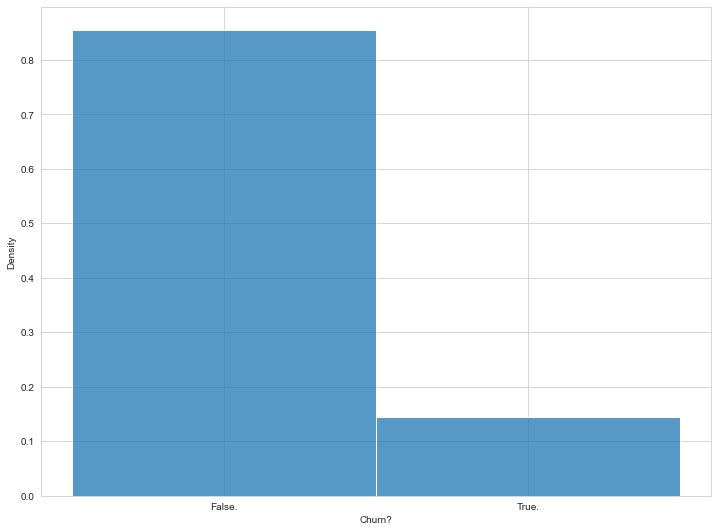

In [7]:
sns.histplot(data['Churn?'], stat='density')

> Данные распределены неравномерно, что важно учесть при разбиении выборки на тестовую и тренировочную

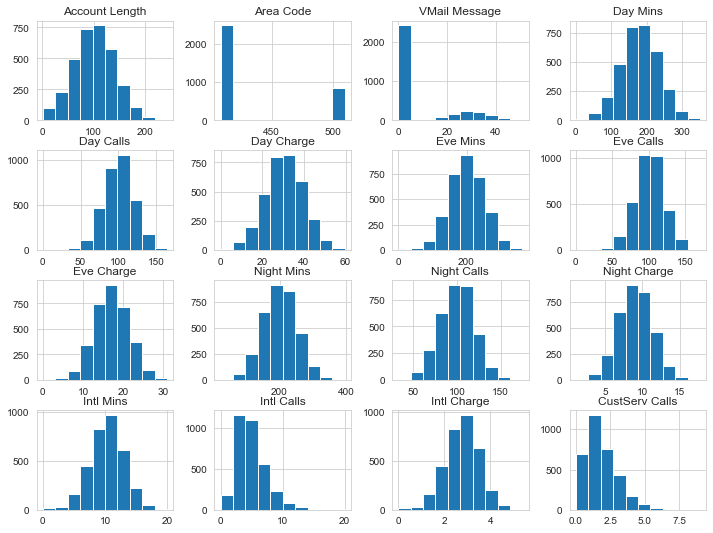

In [8]:
data.hist(figsize=(12, 9))
plt.subplots_adjust()

<AxesSubplot:>

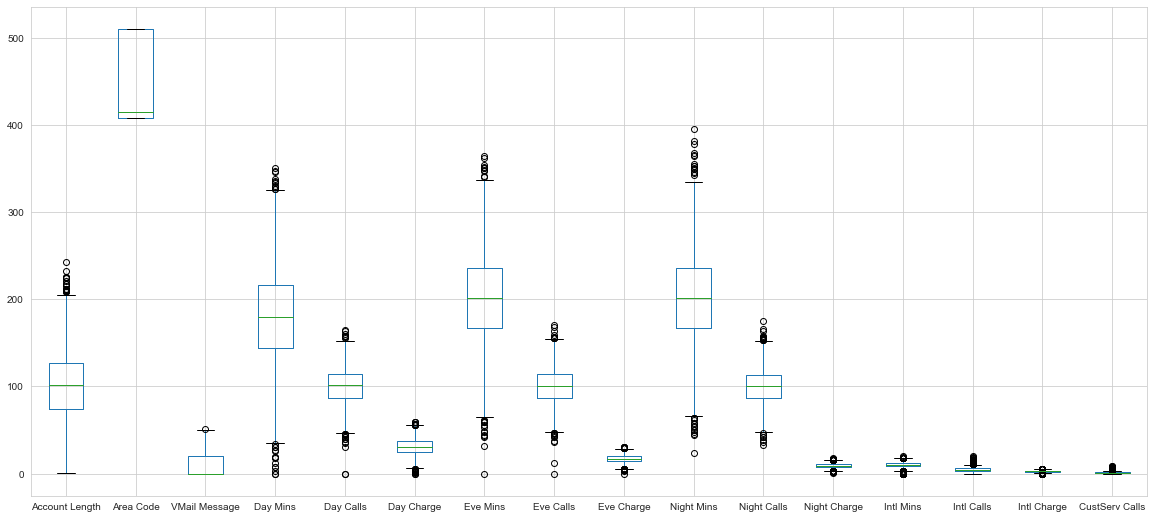

In [909]:
data.boxplot(figsize=(20, 9))

> Все численные данные распределены более-менее равномерно, кроме VMailMessage. Но это заметил только в конце и в конце попробовал отдельно взглянуть на данные без этой фичи

In [9]:
data['Area Code'].unique()

array([415, 408, 510], dtype=int64)

In [10]:
len(data['Phone'].unique())

3333

> Телефон уникальный и не нужен, код оставим как категориальную переменную, но вероятно малозначимую

In [11]:
data['Area Code'] = data['Area Code'].astype('object')

<AxesSubplot:>

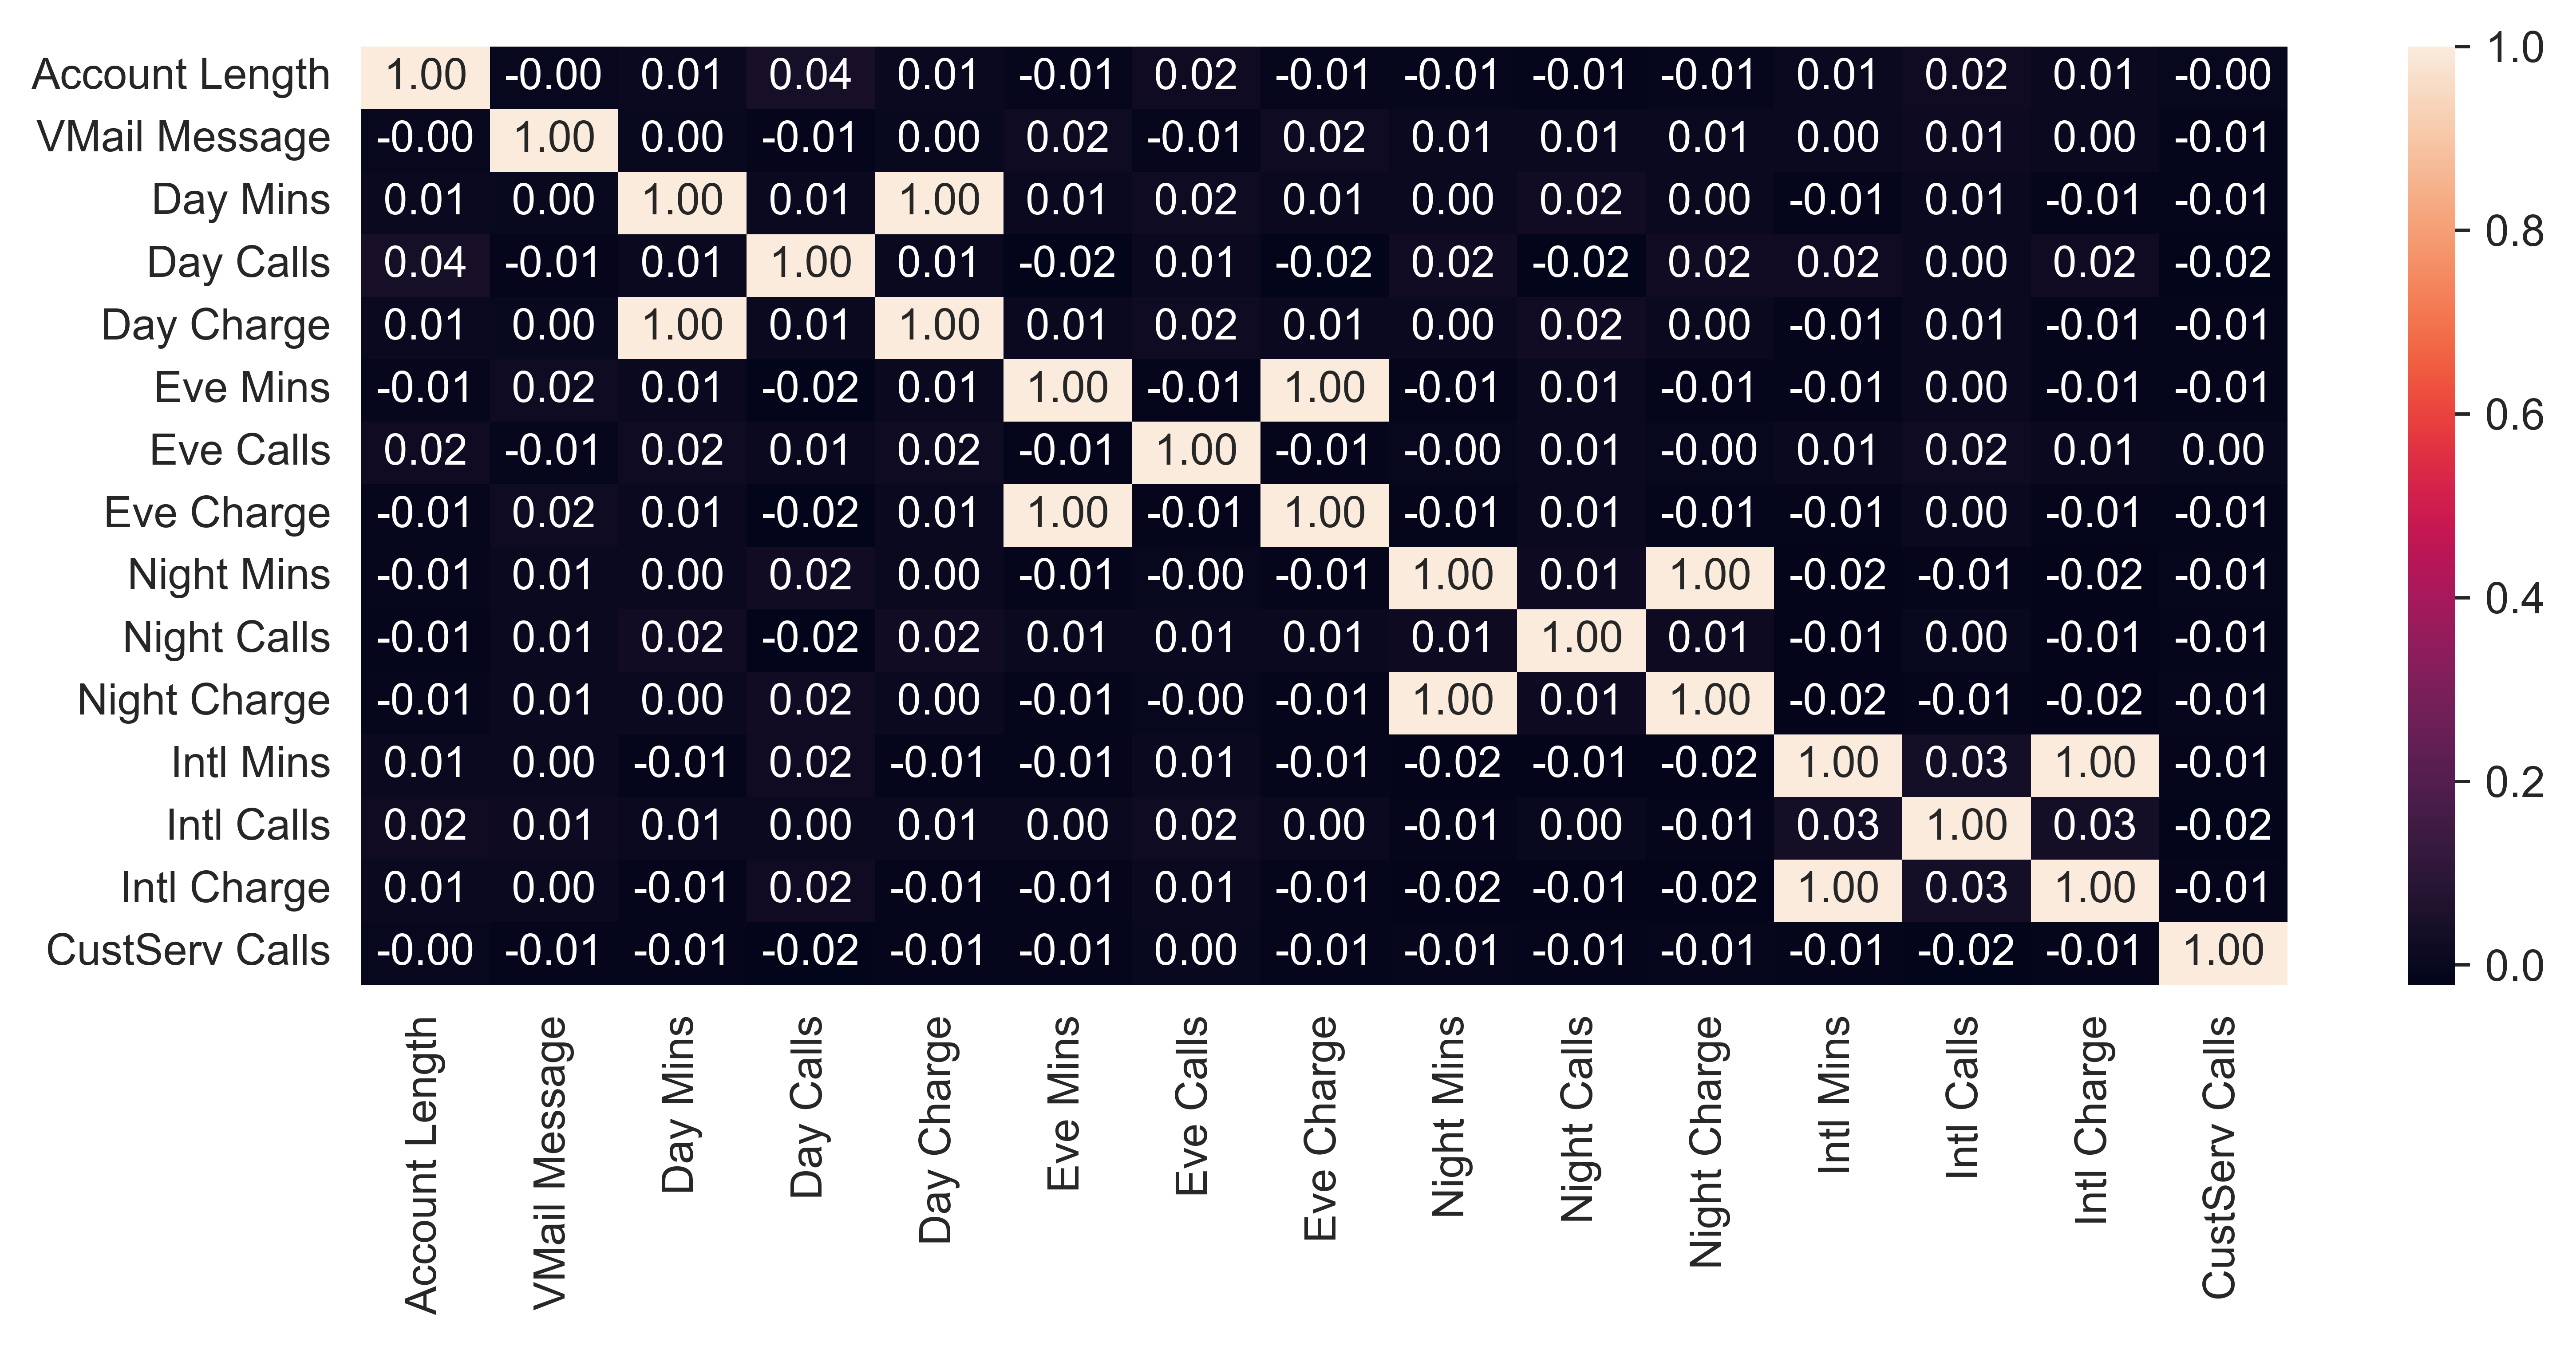

In [12]:
correlation_matrix = data.corr()
plt.figure(figsize=[10,4], dpi=700)
sns.heatmap(data=correlation_matrix, annot=True, fmt=".2f")

> Видно, что существует сильная корреляция между нагрузкой сети по определенным параметрам и проведенным минутам

In [13]:
X = data
X = X.drop(['Day Charge', 'Eve Charge', 'Intl Charge', 'Phone', 'Night Charge', 'Churn?'], axis=1)
y = data['Churn?'].replace({'True.': 1, 'False.': 0})

In [14]:
data.columns

Index(['State', 'Account Length', 'Area Code', 'Phone', 'Int'l Plan',
       'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
       'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
       'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge',
       'CustServ Calls', 'Churn?'],
      dtype='object')

In [15]:
cat_cols = ['State', "Int'l Plan", 'VMail Plan', 'Area Code']
num_cols = ['Account Length', 'VMail Message', 'Day Mins', 'Day Calls',
            'Eve Mins', 'Eve Calls', 'Night Mins', 'Night Calls',
            'Intl Mins', 'Intl Calls', 'CustServ Calls']

preprocessor = ColumnTransformer([("ohe", OneHotEncoder(drop='first'), cat_cols),
                                  ("scaler", StandardScaler(), num_cols)])                                

> Перед тем как проводить анализ особым лесом и бустингом для референса используем стандартные лес с подобранными параметрами, но без оверсемплинга

### RandomForestClassifier

In [16]:
forest_pipeline = Pipeline(steps=[
                            ("preprocessor", preprocessor),
                            ("random_forest", RandomForestClassifier(random_state=SEED))
                            ])

In [17]:
forest_params = {'random_forest__max_depth': range(10,61,5),
                 'random_forest__n_estimators': range(20,100,10),
                 'random_forest__max_features' : range(5,15)}


tree_grid = GridSearchCV(estimator=forest_pipeline, param_grid=forest_params, scoring="f1", cv=5, n_jobs=-1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify = y)

In [19]:
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['State',
                                                                          "Int'l "
                                                                          'Plan',
                                                                          'VMail '
                                                                          'Plan',
                                                                          'Area '
                                                                          'Code']),
                                                                        ('scaler',
                                                                         Standard

In [20]:
tree_grid.best_params_

{'random_forest__max_depth': 15,
 'random_forest__max_features': 13,
 'random_forest__n_estimators': 40}

In [21]:
pipeline_rf = Pipeline(steps=[
                            ("preprocessor", preprocessor),
                            ("random_forest", RandomForestClassifier(max_features=13, max_depth=15, n_estimators = 40, random_state=SEED))
                            ])
cross_val_score(estimator=pipeline_rf, X = X_train, y = y_train, cv=5, scoring="f1").mean()

0.7614404714087211

In [22]:
y_pred = tree_grid.predict(X_test)

In [23]:
y_pred_proba = tree_grid.predict_proba(X_test)

In [24]:
f1_score(y_test, y_pred)

0.7868852459016394

In [25]:
roc_auc_score(y_test, y_pred)

0.8292800967937084

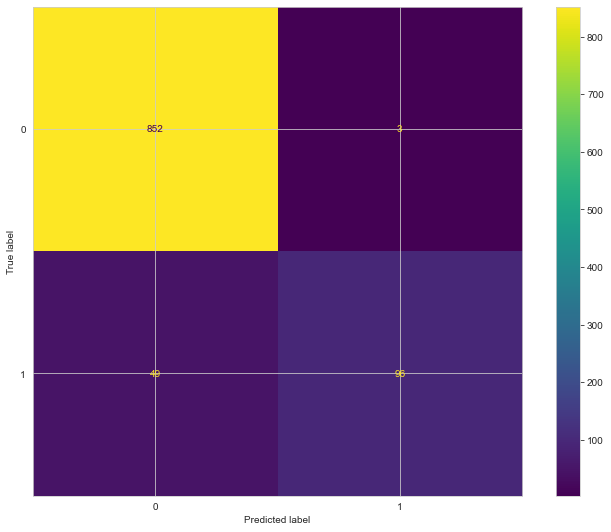

In [26]:
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot();

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.9184029038112523

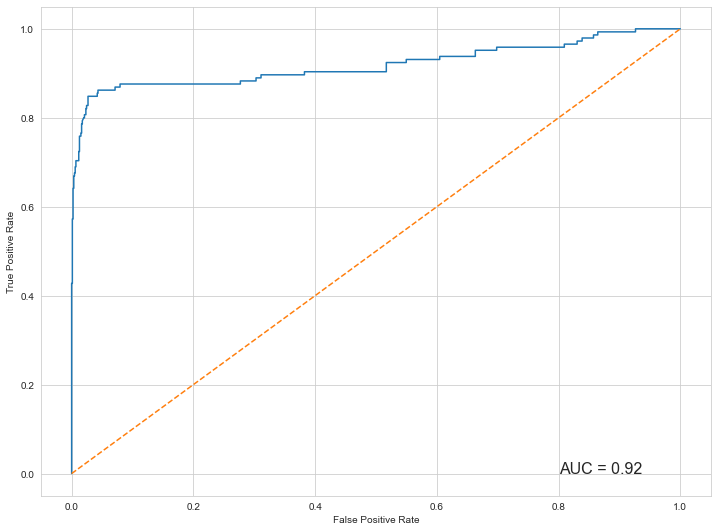

In [28]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.8, 0, s = f'AUC = {round(roc_auc, 2)}', fontsize=16) 
plt.show()

> В целом, даже так неплохо, но видно, что модель сильно недопредсказывает уход, хотя в нашем случае лучше бы перепредсказывала

### xgboost.XGBClassifier

> Сперва хотел подбирать параметры по-умному, но прикинул время вычислений на моем ноуте и понял, что это даже при небольшом подборе займет очень много часов (а при более-менее нормальном - 13000 часов). Поэтому делал ручками

In [772]:
xg_class = xgboost.XGBClassifier(objective = 'binary:logistic', 
                                   eval_metric = 'error',
                                   max_depth = 12,  
                                   eta = 0.2, # learning rate analog
                                   gamma = 3, # threshold for split
                                   max_delta_step = 4, # for imbalanced classes
                                   n_estimators = 100,
                                   min_child_weight = 2, #min_leaves
                                   scale_pos_weight = 1.75,
                                   colsample_bytree = 0.7, #number of features
                                   random_state=SEED)

> Чтобы выровнять неравенство таргетов использовал max_delta_step в лесе и SMOTE и RandomUnderSampler в пайплайне

In [905]:
xg_class_pipeline = make_pipeline(preprocessor, SMOTE(random_state = SEED),
                                  RandomUnderSampler(random_state = SEED),
                                  xg_class)

In [774]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify = y)

In [775]:
xg_class_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['State', "Int'l Plan",
                                                   'VMail Plan', 'Area Code']),
                                                 ('scaler', StandardScaler(),
                                                  ['Account Length',
                                                   'VMail Message', 'Day Mins',
                                                   'Day Calls', 'Eve Mins',
                                                   'Eve Calls', 'Night Mins',
                                                   'Night Calls', 'Intl Mins',
                                                   'Intl Calls',
                                                   'CustServ Calls'])])),
                ('smote', SMOTE(random_state=11...
                      

In [776]:
y_pred = xg_class_pipeline.predict(X_test)

In [777]:
y_pred_proba = xg_class_pipeline.predict_proba(X_test)

In [778]:
f1_score(y_test, y_pred)

0.8654545454545454

In [779]:
roc_auc_score(y_test, y_pred)

0.9039120790481953

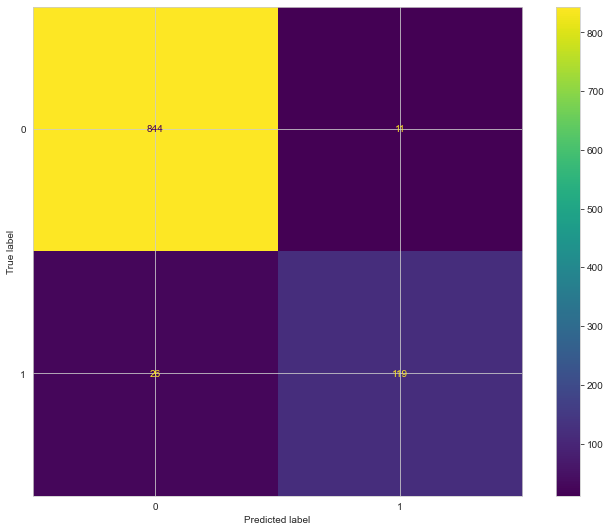

In [780]:
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot();

In [781]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.9292679975801572

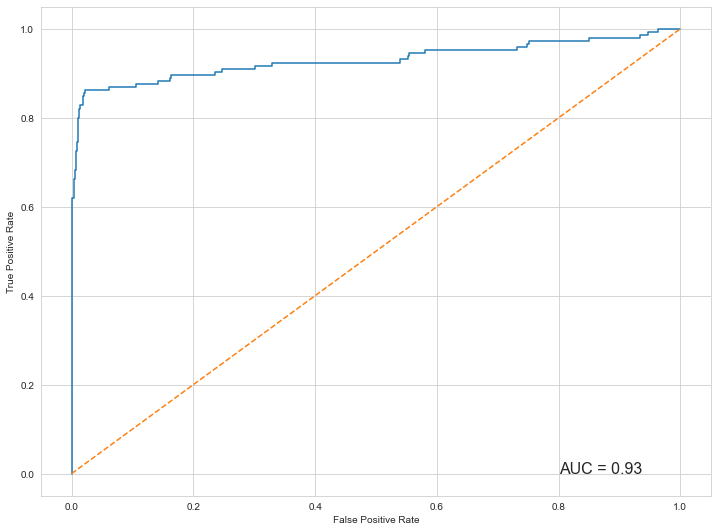

In [782]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.8, 0, s = f'AUC = {round(roc_auc, 2)}', fontsize=16) 
plt.show()

> Удалось неплохо улучшить относительно референсу по f1 и roc-auc из-за того, что возросло число верно предсказанных объектов.

Дальше подбирал параметры для бустинга

### xgboost.XGBRFClassifier

In [568]:
xg_boost = xgboost.XGBRFClassifier(objective = 'binary:logistic', 
                                   eval_metric = 'error',
                                   max_depth = 15,  
                                   eta = 0.2, # learning rate analog
                                   gamma = 3, # threshold for split
                                   max_delta_step = 3, # for imbalanced classes
                                   n_estimators = 150,
                                   min_child_weight = 2, #min_leaves
                                   scale_pos_weight = 1.75,
                                   colsample_bytree = 0.8, #number of features
                                   random_state=SEED)

In [569]:
xg_pipeline = make_pipeline(preprocessor,SMOTE(random_state = SEED),
                            RandomUnderSampler(random_state = SEED),
                            xg_boost)

In [570]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify = y)

In [571]:
xg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['State', "Int'l Plan",
                                                   'VMail Plan', 'Area Code']),
                                                 ('scaler', StandardScaler(),
                                                  ['Account Length',
                                                   'VMail Message', 'Day Mins',
                                                   'Day Calls', 'Eve Mins',
                                                   'Eve Calls', 'Night Mins',
                                                   'Night Calls', 'Intl Mins',
                                                   'Intl Calls',
                                                   'CustServ Calls'])])),
                ('smote', SMOTE(random_state=11...
                      

In [572]:
y_pred = xg_pipeline.predict(X_test)

In [573]:
y_pred_proba = xg_pipeline.predict_proba(X_test)

In [574]:
f1_score(y_test, y_pred)

0.8362369337979093

In [575]:
roc_auc_score(y_test, y_pred)

0.9009276063722524

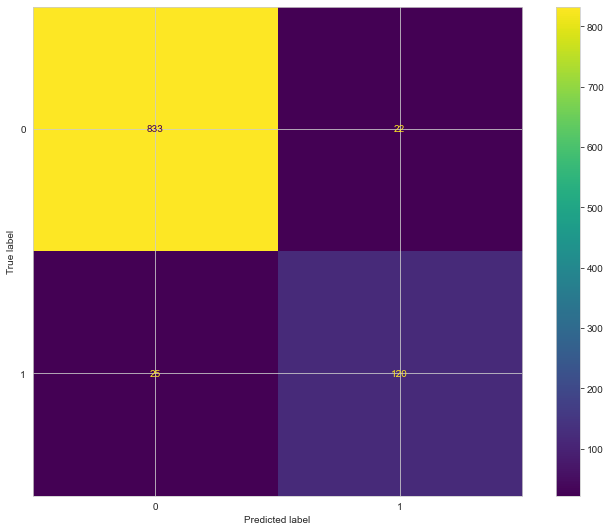

In [576]:
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot();

In [577]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.9256704980842912

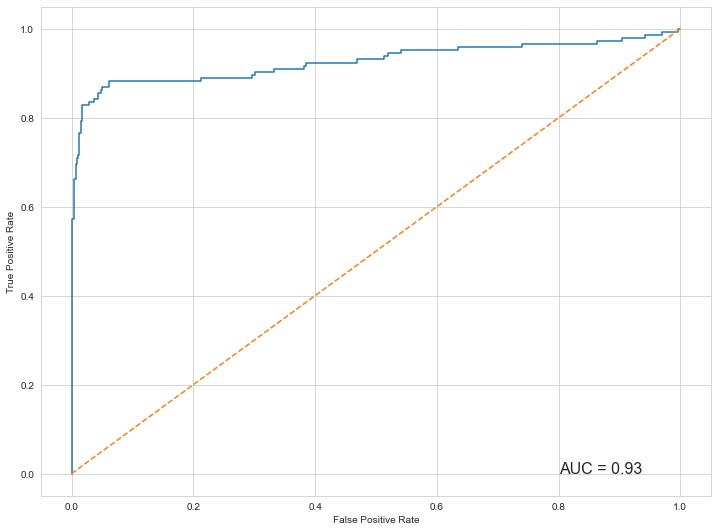

In [578]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.8, 0, s = f'AUC = {round(roc_auc, 2)}', fontsize=16) 
plt.show()

> Бустинг тоже дает неплохое предсказание, но хуже, чем лес (больше ложноположительных результатов)

### Комбинация Случайного леса и XG

Здесь я подумал скомбинировать два леса, чтобы повысить эффективность предсказания, но результат не был выше, чем отдельных составных частей. Видимо, они оба не собирают какие-то неочевидные таргеты, а кросс-кореляция только понижает качество модели

Сперва выровнял Случайный лес и подобрал гиперпараметры

In [810]:
fr_pipeline = make_pipeline(preprocessor,SMOTE(random_state = SEED),
                            RandomUnderSampler(random_state = SEED),
                            RandomForestClassifier(random_state=SEED))
forest_params = {'randomforestclassifier__max_depth' : range(1,20,2),
                 'randomforestclassifier__n_estimators' : range(20,100,10),
                 'randomforestclassifier__max_features': range(5,15)}


tree_grid = GridSearchCV(estimator=fr_pipeline, param_grid=forest_params, scoring="f1", cv=5, n_jobs=-1)
tree_grid.fit(X_train, y_train)
print(tree_grid.best_params_)

{'randomforestclassifier__max_depth': 19, 'randomforestclassifier__max_features': 13, 'randomforestclassifier__n_estimators': 80}


In [916]:
fr_pipeline = make_pipeline(preprocessor,SMOTE(random_state = SEED),
                            RandomUnderSampler(random_state = SEED),
                            RandomForestClassifier(random_state=SEED, max_depth = 19,
                                                   max_features = 13, n_estimators = 80))

In [917]:
base_models_upd = [("XGB_RF", xg_class_pipeline), ("rf_upd", fr_pipeline)]

In [918]:
voting_soft = VotingClassifier(estimators=base_models_upd, voting = 'soft')
scores = cross_val_score(voting_soft, X_train, y_train, cv=5, scoring="f1")
print(scores.mean())

0.7909620424550751


In [926]:
voting_hard = VotingClassifier(estimators=base_models_upd)
scores = cross_val_score(voting_hard, X_train, y_train, cv=5, scoring="f1")
print(scores.mean())

0.7565442613491349


In [927]:
voting_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('XGB_RF',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('ohe',
                                                                                OneHotEncoder(drop='first'),
                                                                                ['State',
                                                                                 "Int'l "
                                                                                 'Plan',
                                                                                 'VMail '
                                                                                 'Plan',
                                                                                 'Area '
                                                                                 'Code']),
                                                                    

In [928]:
y_ped_vs = voting_soft.predict(X_test)

In [929]:
f1_score(y_test, y_ped_vs)

0.855072463768116

In [930]:
y_pred_proba_sv = voting_soft.predict_proba(X_test)

In [931]:
roc_auc_score(y_test, y_ped_vs)

0.8992942125428512

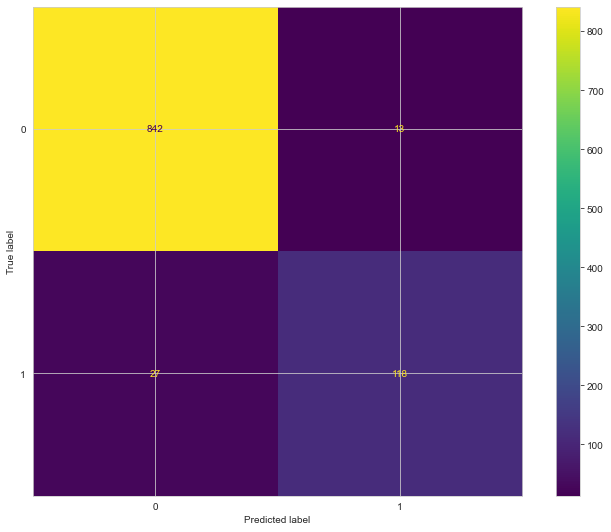

In [932]:
matrix = confusion_matrix(y_test, y_ped_vs)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot();

In [933]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_sv[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.9205968945351887

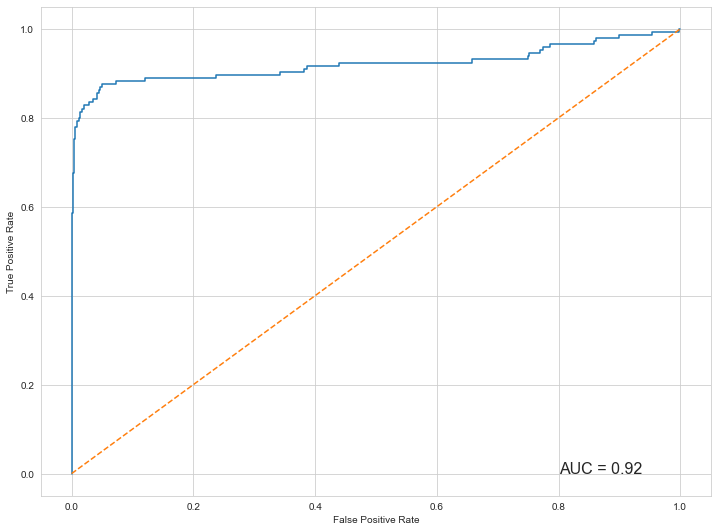

In [934]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.8, 0, s = f'AUC = {round(roc_auc, 2)}', fontsize=16) 
plt.show()

Результат  не оправдал ожиданий

### Кластеризация

Дальше я попробовал оценить, можно ли выделить кластеры из этих данных на основе ухода клиентов

In [858]:
data_true = data.loc[data['Churn?'] == 'True.']
data_f = data.loc[data['Churn?'] == 'False.']

0     403
29      8
26      6
32      6
33      6
28      6
31      5
42      4
35      4
36      4
27      3
41      3
34      2
18      2
44      2
22      2
21      2
20      2
37      2
30      2
15      1
45      1
19      1
48      1
16      1
38      1
40      1
17      1
24      1
Name: VMail Message, dtype: int64


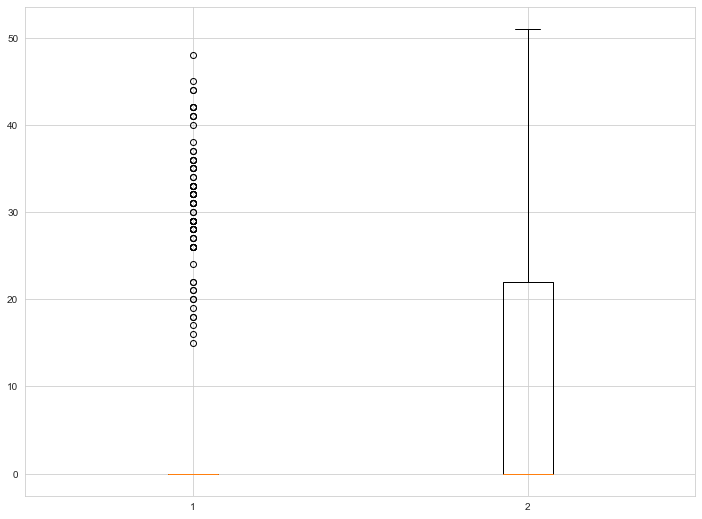

In [938]:
print(data_true['VMail Message'].value_counts())
plt.boxplot((data_true['VMail Message'], data_f['VMail Message']));

> Заметно, что у тех, кто уходит ярко выражены выбросы, но видимо это различие связано в неэквивалентности числа данных

In [859]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
pca.fit(data_true[num_cols])

pca = PCA().fit(data_true[num_cols])
pca_embedding = pca.transform(data_true[num_cols])

tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
            perplexity=30)
tsne_embedding = tnse.fit_transform(pca_embedding)

In [860]:
pca_f = PCA(n_components=2).fit(data_f[num_cols])
pca_embedding_f = pca_f.transform(data_f[num_cols])

tnse_f = TSNE(n_components=2, init=pca_embedding_f[:, :2], n_jobs=-1,
            perplexity=30)
tsne_embedding_f = tnse_f.fit_transform(pca_embedding_f)

Text(0, 0.5, '$TSNE_2$')

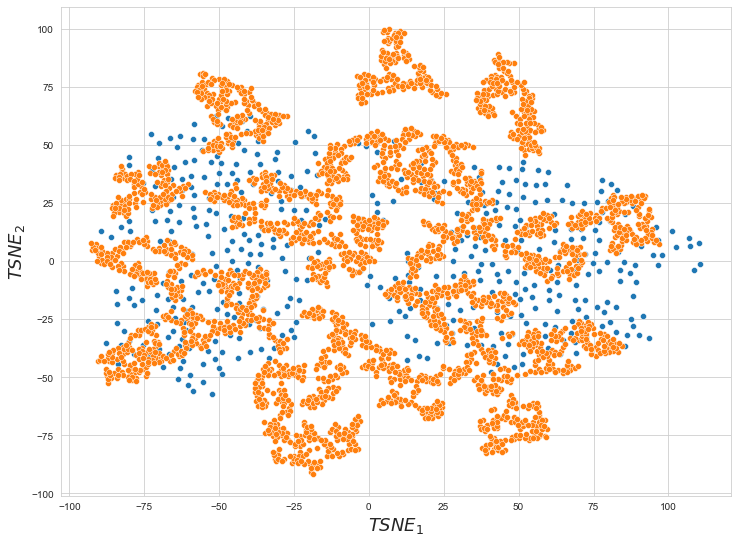

In [861]:
sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    palette="colorblind")
sns.scatterplot(x=tsne_embedding_f[:, 0],
                    y=tsne_embedding_f[:, 1])
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

> Да, тут уже заметно, что данные при понижение размерности до 2 не образуют кластеры (но не знаю, чего я ожидал)

Дальше я попробовал дропнуть VMail Message, но модель стала от этого только хуже

In [940]:
X = data
X = X.drop(['Day Charge', 'Eve Charge', 'Intl Charge', 'Phone', 'Night Charge', 'Churn?', 'VMail Message'], axis=1)
y = data['Churn?'].replace({'True.': 1, 'False.': 0})

cat_cols = ['State', "Int'l Plan", 'VMail Plan', 'Area Code']
num_cols = ['Account Length', 'Day Mins', 'Day Calls',
            'Eve Mins', 'Eve Calls', 'Night Mins', 'Night Calls',
            'Intl Mins', 'Intl Calls', 'CustServ Calls']

preprocessor = ColumnTransformer([("ohe", OneHotEncoder(drop='first'), cat_cols),
                                  ("scaler", StandardScaler(), num_cols)])                                

xg_class = xgboost.XGBClassifier(objective = 'binary:logistic', 
                                   eval_metric = 'error',
                                   max_depth = 12,  
                                   eta = 0.2, # learning rate analog
                                   gamma = 3, # threshold for split
                                   max_delta_step = 4, # for imbalanced classes
                                   n_estimators = 100,
                                   min_child_weight = 2, #min_leaves
                                   scale_pos_weight = 1.75,
                                   colsample_bytree = 0.7, #number of features
                                   random_state=SEED)

xg_class_pipeline = make_pipeline(preprocessor,SMOTE(random_state = SEED),
                            RandomUnderSampler(random_state = SEED),
                            xg_class)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify = y)

xg_class_pipeline.fit(X_train, y_train)

y_pred = xg_class_pipeline.predict(X_test)
y_pred_proba = xg_class_pipeline.predict_proba(X_test)

In [897]:
f1_score(y_test, y_pred)

0.8500000000000001

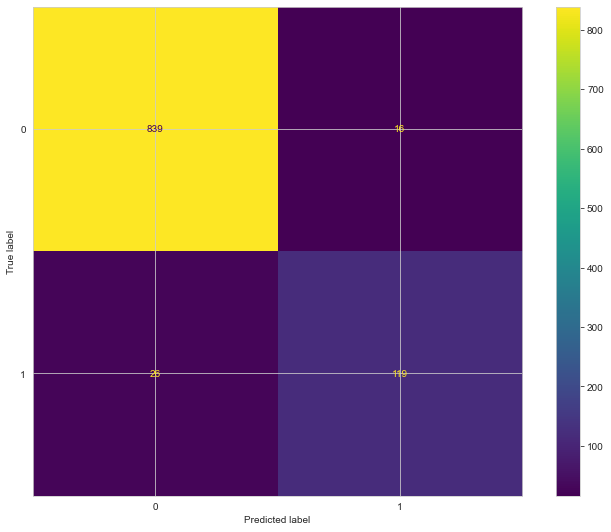

In [899]:
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot();

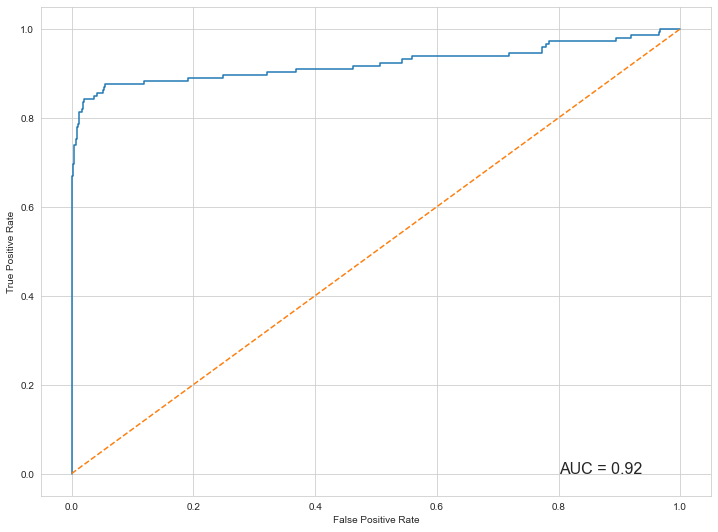

In [939]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.8, 0, s = f'AUC = {round(roc_auc, 2)}', fontsize=16) 
plt.show()

Тогда мой лучший результат был получен на xgboost.XGBClassifie

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

In [945]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://mempro.ru/wp-content/uploads/2022/10/0-6.jpg")

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Было интересно, но подбор гиперпараметры вручную похоже на отдельное машинное обучение